We will now use python to do some wavelet analysis. As usual, we have to import a few packages.

In [9]:
import h5py
import spectrum
import analytic_wavelet
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

from scipy import signal, ndimage, fft
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


sns.set()
sns.set_style("whitegrid")

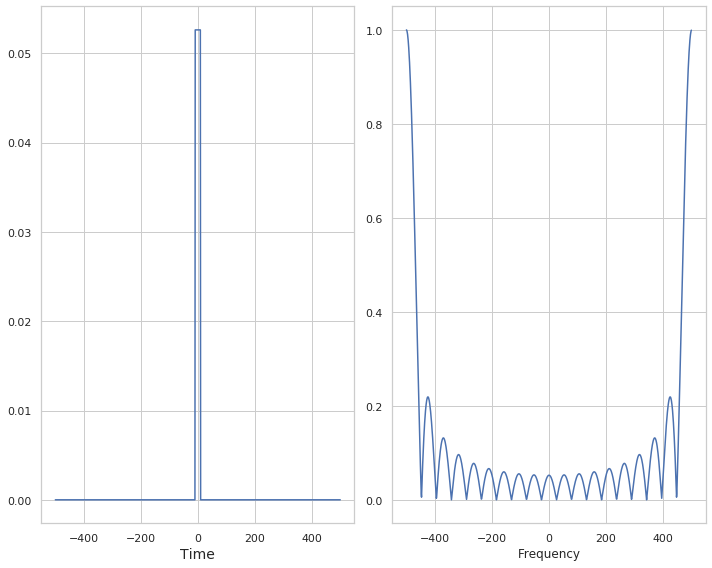

In [3]:
t = np.arange(1, 1002)
t = t - np.mean(t)
g = np.zeros(len(t))
g[np.abs(t) < 10] = 1/19

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(t, g)
ax[0].set_xlabel("Time", fontsize=14)

ax[1].plot(t, np.abs(fft(g)))
ax[1].set_xlabel("Frequency")

fig.tight_layout()

Hello

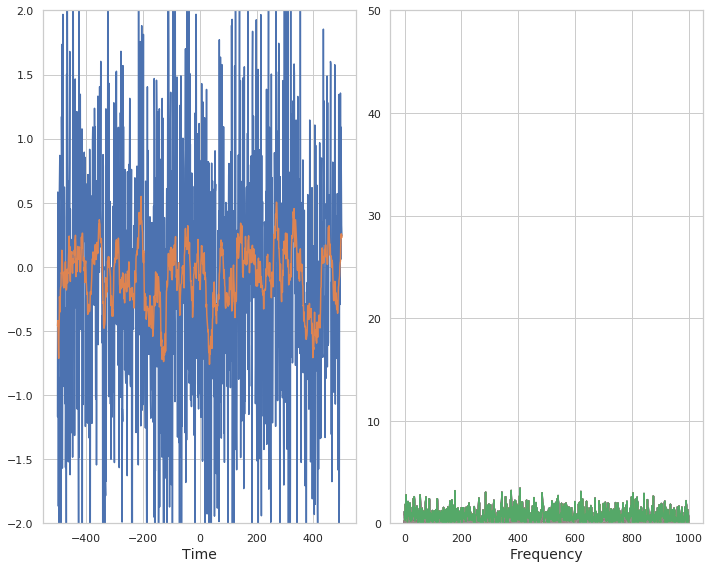

In [4]:
x = np.random.randn(1001,1)
fx = ndimage.convolve1d(x, np.ones(19)/19, mode="mirror", axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(t, x)
ax[0].plot(t, fx)
ax[0].set_xlabel("Time", fontsize=14)
ax[0].set_ylim(-2, 2)

ax[1].plot(np.abs(fft(x)))
ax[1].plot(np.abs(fft(fx)))
ax[1].plot(np.abs(fft(x)*fft(g)))
ax[1].set_xlabel("Frequency", fontsize=14)
ax[1].set_ylim(0, 50)

fig.tight_layout()

Hello

In [55]:
datadir = "../data/"
filename = "m1244.mat"
with h5py.File(datadir + filename,'r') as file:
    # Looking at contents of file
    print(file.keys())
    # Finding the variables contained in the key
    variables = list(file.get("{}".format(filename[:filename.find(".")])))
    print(variables)

    # Storing the variables in a dictionary
    data = {}
    for i in variables:
        data[i] = np.array(file.get("{0}/{1}".format(filename[:filename.find(".")], i))).squeeze()  # removes excessive dims

    # Convert a complex tuple (real, imag) to a complex number a + jb
    cv = np.zeros((data["cv"].shape[0], data["cv"].shape[1]), dtype=complex)
    for i in range(len(data["cv"])):
        for j in range(len(data["cv"][0])):
            cv[i][j] = data["cv"][i][j][0] + 1j*data["cv"][i][j][1]
    data["cv"] = cv

    # Convert matlab datenum format to a datetime object for aesthetics
    num = []
    for i in data["num"]:
        num.append(dt.datetime.fromordinal(int(i)) + dt.timedelta(days=i%1) - dt.timedelta(days = 366))
    num_old = data["num"]
    data["num"] = np.array(num)

<KeysViewHDF5 ['#refs#', 'm1244']>
['creator', 'cv', 'depths', 'description', 'lat', 'link', 'lon', 'num', 'p', 't', 'timestamp']


Hello

<IPython.core.display.Javascript object>


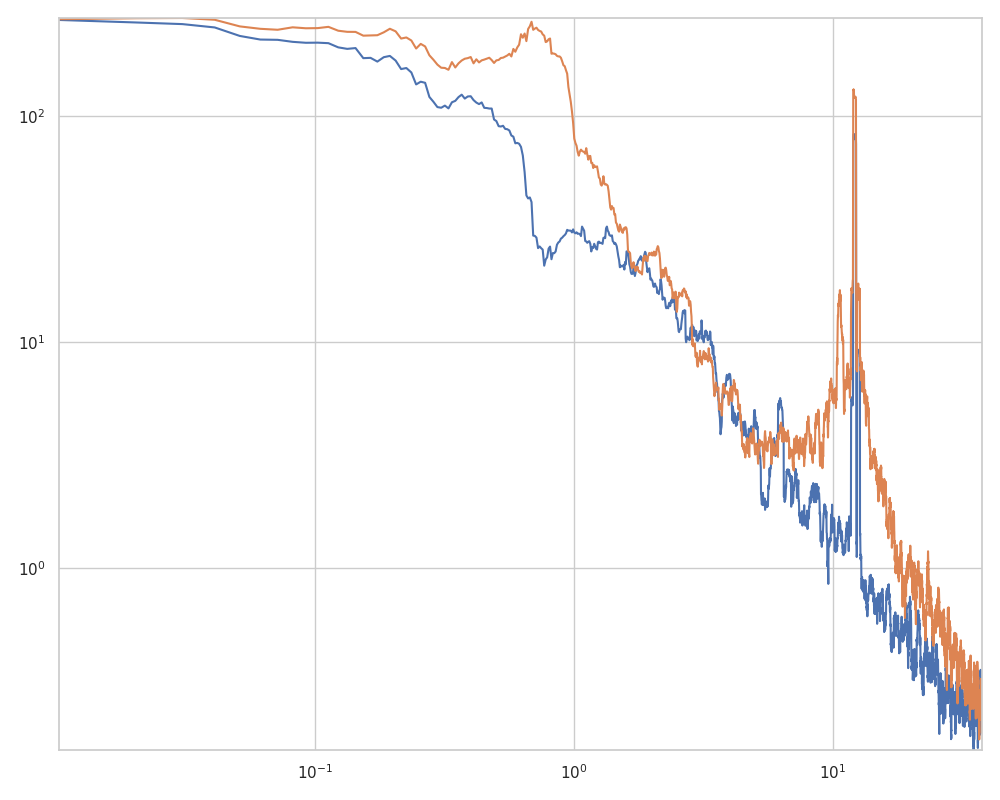

In [10]:
delta = data["num"][1] - data["num"][0]
delta = delta.seconds/60/60/24  # sample rate in days
cv3 = data["cv"][3]
cv3_centered = cv3 - np.mean(cv3)

f, p = signal.periodogram(cv3_centered, fs=1/delta*2*np.pi, return_onesided=False)

NW = 16
Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cv3_centered, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cv3_centered))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
p = np.mean(Sk*eigenvalues, axis=1) * delta

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.loglog(f[f >= 0], p[np.where(f >= 0)])
ax.loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
ax.autoscale(enable=True, tight=True)
fig.tight_layout()

 

Now for wavelet smoothing

<IPython.core.display.Javascript object>


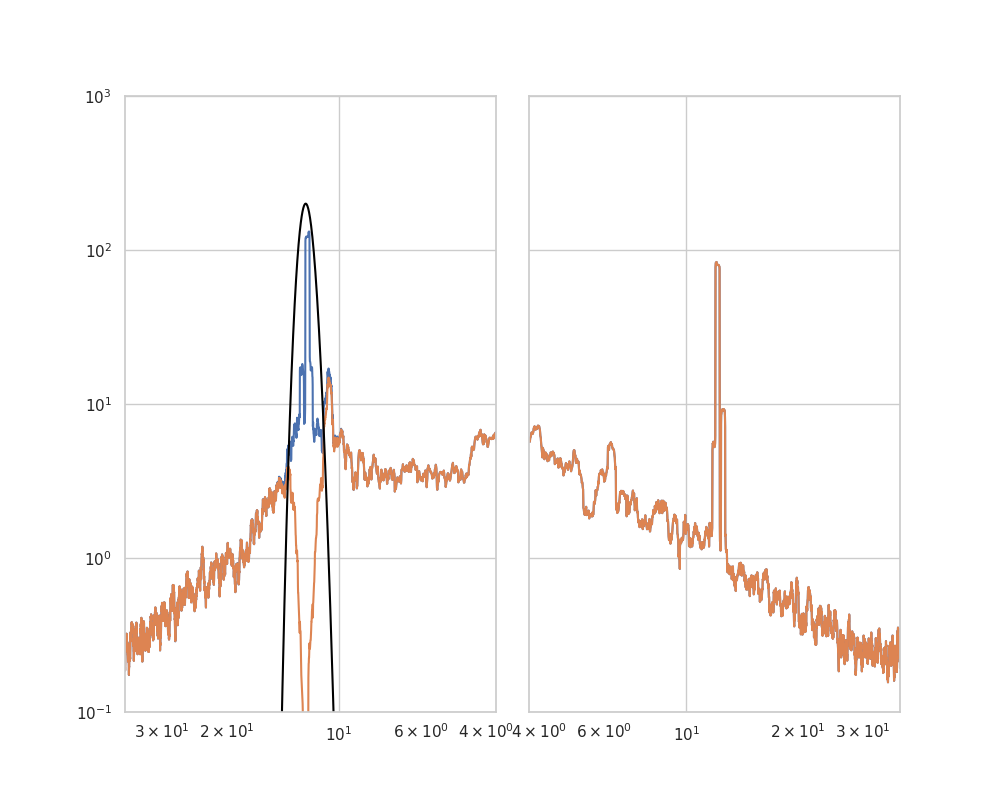

(0.1, 1000.0)

In [11]:
gamma = 3
beta = 100
omega=2*np.pi*1200/len(cv3_centered)

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
psi, psif = morse.make_wavelet(len(cv3_centered), omega)

cvo = 1/np.sqrt(2)*np.conj(analytic_wavelet.analytic_wavelet_transform(np.conj(cv3_centered), psif, False)).flatten()
cvr = cv3_centered - cvo


Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvo, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvo))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
po = np.mean(Sk*eigenvalues, axis=1) * delta

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvr, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvr))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
pr = np.mean(Sk*eigenvalues, axis=1) * delta

psi, psif = morse.make_wavelet(len(cv3_centered), omega)


fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True, gridspec_kw={"wspace": 0.09})

ax[0].loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
ax[0].loglog(np.abs(f[f < 0]), pr[np.where(f < 0)])
ax[0].loglog(f[f >= 0], 50*psif[0][:len(f[f >= 0])]**2, color="black")
ax[0].set_xlim(np.max(f)/10, np.max(f))
ax[0].set_ylim(1e-1, 1e3)
ax[0].invert_xaxis()

ax[1].loglog(f[f >= 0], p[np.where(f >= 0)])
ax[1].loglog(f[f >= 0], pr[np.where(f >= 0)])
ax[1].set_xlim(np.max(f)/10, np.max(f))
ax[1].set_ylim(1e-1, 1e3)

Next

<IPython.core.display.Javascript object>


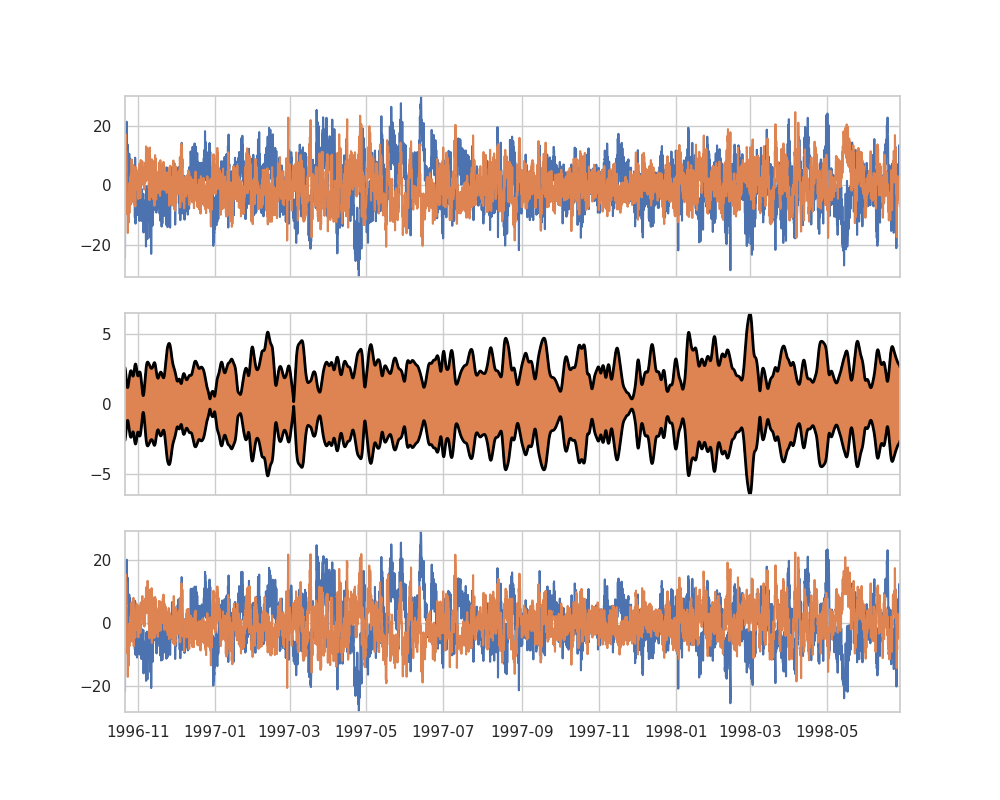

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax[0].plot(num, cv3_centered.real)
ax[0].plot(num, cv3_centered.imag)
ax[0].autoscale(enable=True, tight=True)

ax[1].plot(num, cvo.real)
ax[1].plot(num, cvo.imag)
ax[1].plot(num, np.abs(cvo), color="black", linewidth=2)
ax[1].plot(num, -np.abs(cvo), color="black", linewidth=2)
ax[1].autoscale(enable=True, tight=True)

ax[2].plot(num, cvr.real)
ax[2].plot(num, cvr.imag)
ax[2].autoscale(enable=True, tight=True)

We will now remove the tidal peak

<IPython.core.display.Javascript object>


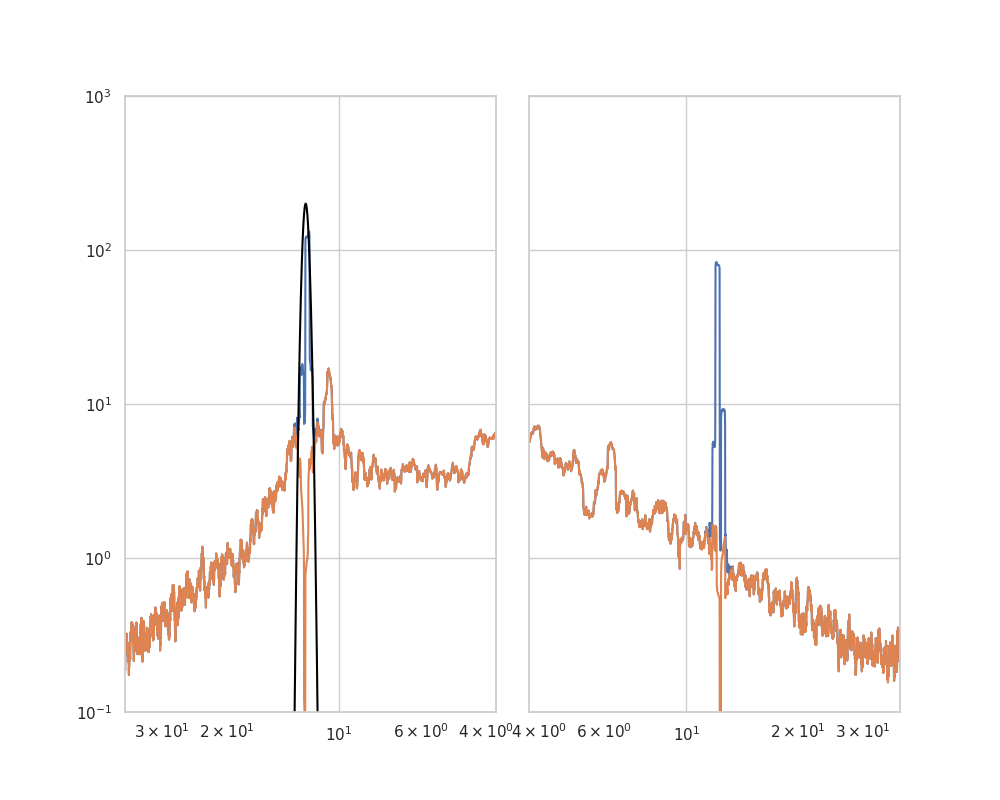

(0.1, 1000.0)

In [13]:
gamma = 3
beta = 500
omega = 2*np.pi*1200/len(cv3_centered)

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
psi, psif = morse.make_wavelet(len(cv3_centered), omega)

cvo1 = analytic_wavelet.analytic_wavelet_transform(cv3_centered, psif, False).flatten()
cvo2 = np.conj(analytic_wavelet.analytic_wavelet_transform(np.conj(cv3_centered), psif, False)).flatten()
cvo = 1/np.sqrt(2)*(cvo1 + cvo2)
cvr = cvo - cv3_centered

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvo, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvo))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
po = np.mean(Sk*eigenvalues, axis=1) * delta

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvr, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvr))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
pr = np.mean(Sk*eigenvalues, axis=1) * delta


fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True, gridspec_kw={"wspace": 0.09})

ax[0].loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
ax[0].loglog(np.abs(f[f < 0]), pr[np.where(f < 0)])
ax[0].loglog(f[f >= 0], 50*psif[0][:len(f[f >= 0])]**2, color="black")
ax[0].set_xlim(np.max(f)/10, np.max(f))
ax[0].set_ylim(1e-1, 1e3)
ax[0].invert_xaxis()

ax[1].loglog(f[f >= 0], p[np.where(f >= 0)])
ax[1].loglog(f[f >= 0], pr[np.where(f >= 0)])
ax[1].set_xlim(np.max(f)/10, np.max(f))
ax[1].set_ylim(1e-1, 1e3)

Now for a wavelet transform

<IPython.core.display.Javascript object>


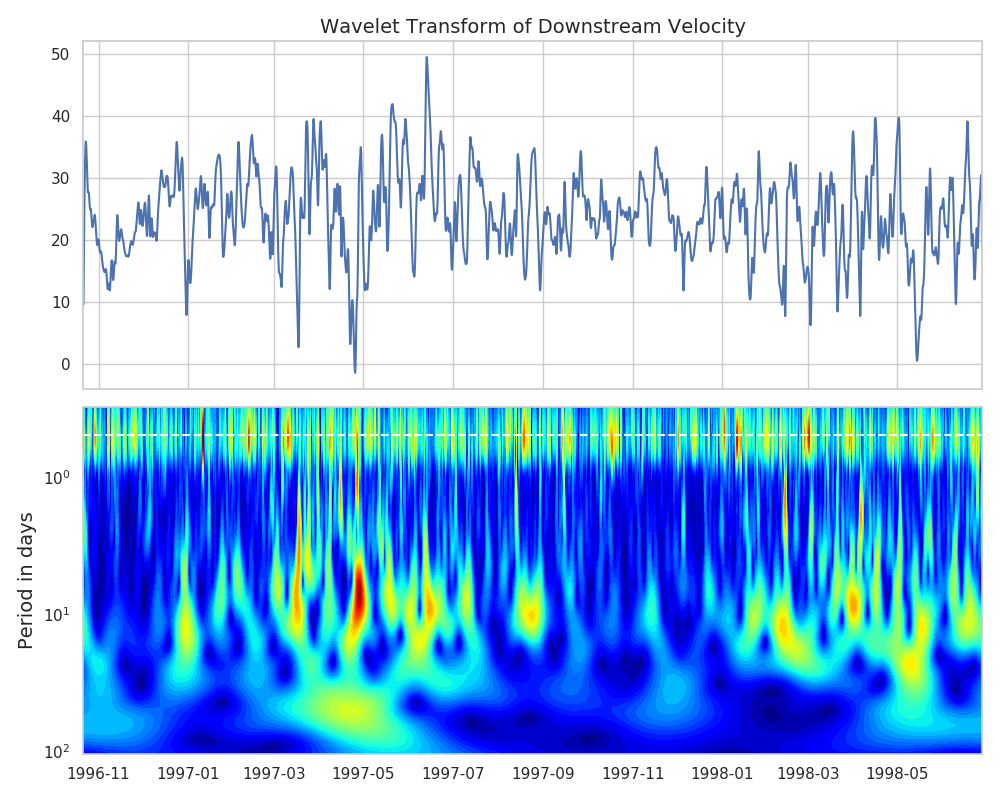

In [16]:
delta = data["num"][1] - data["num"][0]  # sample rate as dt.timedelta object
delta = delta.seconds/60/60/24  # sample rate in days

phi = np.angle(np.mean(cv[3]))

u = (cv[3]*np.exp(-phi*1j)).real

gamma = 3
beta = 2

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)  # create morse wavelet object (class instance)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))  # use object to construct frequency space
psi, psif = morse.make_wavelet(len(u), fs)  # use object to create a morse wavelet in time and frequency space

transform = analytic_wavelet.analytic_wavelet_transform(u, psif, False)


window = signal.windows.hann(24)  # construct Hanning window
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)  # smooth by convolving speed with window

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed)  # internal function for plotting time series

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform,
                                      levels=50,
                                      cmap=cmap,
                                      vmin=0,
                                      vmax=15
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].set_ylabel("Period in days", fontsize=14)
ax[1].invert_yaxis()
ax[1].set_yscale("log")

#fig.colorbar(c, ax=ax[1])
ax[0].set_title("Wavelet Transform of Downstream Velocity", fontsize=14)
fig.tight_layout()

We will now take a look at the wavelets

<IPython.core.display.Javascript object>


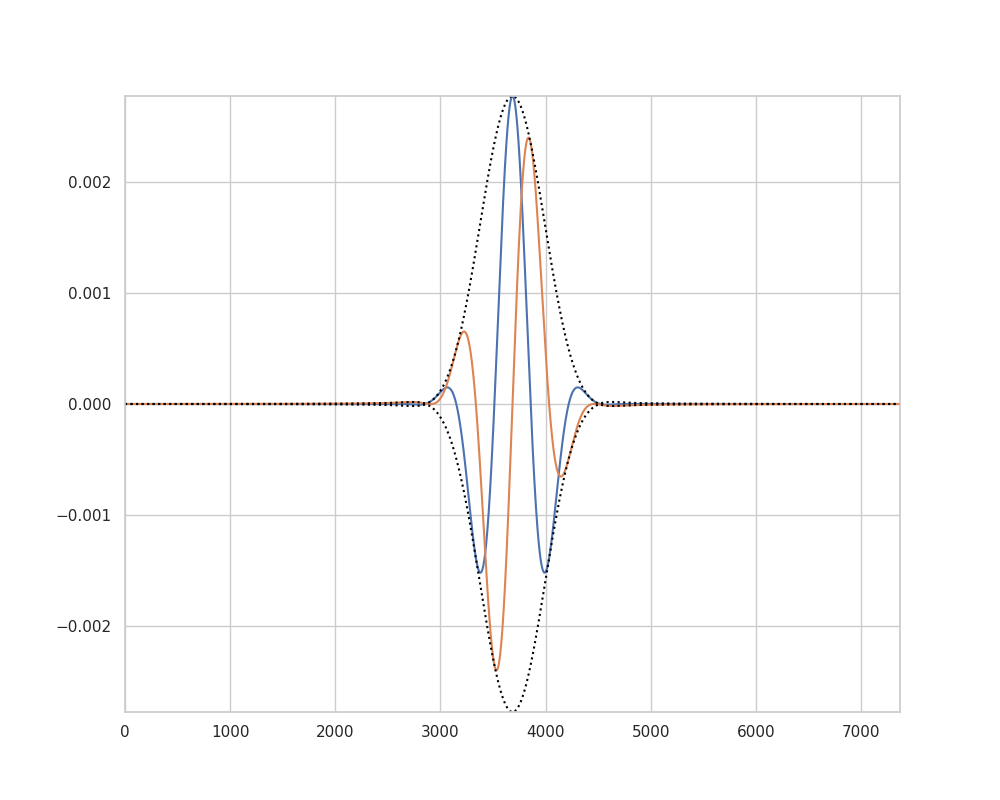

In [22]:
psi, psif = morse.make_wavelet(len(u), fs)
fso = fs[54]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.autoscale(enable=True, tight=True)

ax.plot(psi[54, :].real)
ax.plot(psi[54, :].imag)
ax.plot(np.abs(psi[54, :]), color="black", linestyle=":")
ax.plot(-np.abs(psi[54, :]), color="black", linestyle=":")

Taking a look at a few more

<IPython.core.display.Javascript object>


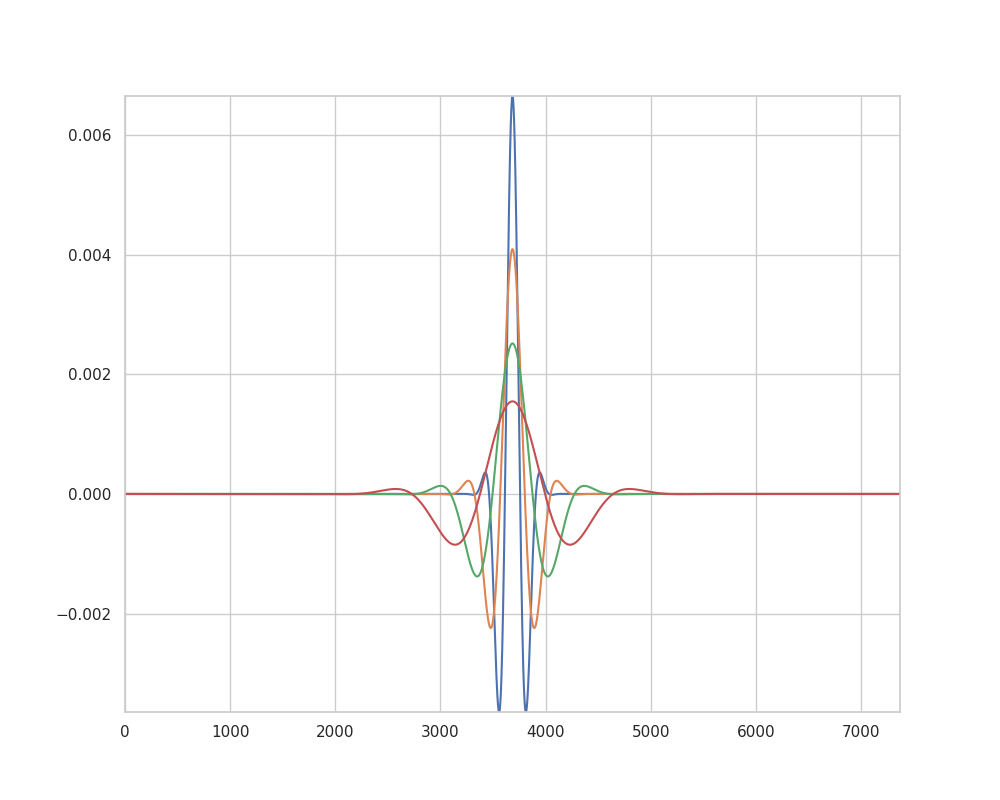

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.autoscale(enable=True, tight=True)

index = [45, 50, 55, 60]
for i in index:
    ax.plot(psi[i, :].real)


Fourier domain

<IPython.core.display.Javascript object>


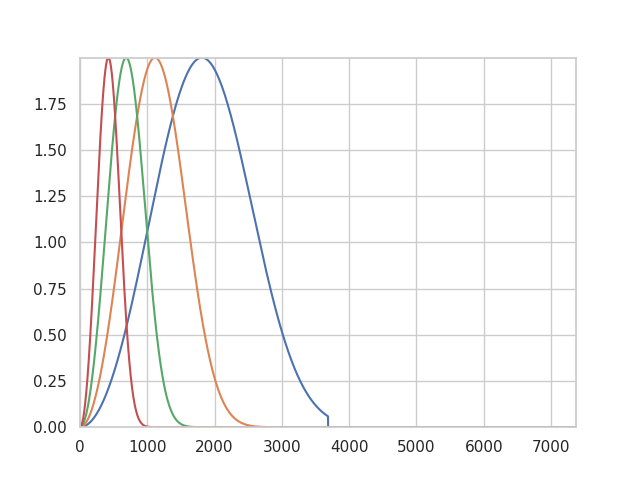

In [33]:
fig, ax = plt.subplots(1, 1)
ax.autoscale(enable=True, tight=True)

index = [1, 6, 11, 16]
for i in index:
    ax.plot(psif[i, :])

Lets change beta

<IPython.core.display.Javascript object>


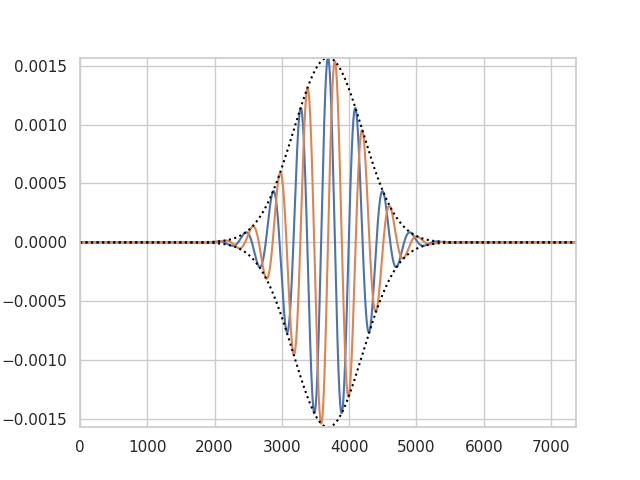

"\ngamma=3;beta=20;\n%Recompute the frequency array, with non-default settings\nfs=morsespace(gamma,beta,{0.1,pi},{1,length(u)});  \n[psi,psif]=morsewave(length(u),gamma,beta,fs);\n%Find the new wavelet having the same frequency as wavelet #55 we looked at earlier\n[temp,index]=min(abs(fs-fso));\nclf,uvplot(psi(:,index)),axis tight\nhold on, plot(abs(psi(:,index)),'k:')\nhold on, plot(-abs(psi(:,index)),'k:')"

In [40]:
gamma = 3
beta = 20

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))
psi, psif = morse.make_wavelet(len(u), fs)

index = np.argmin(np.abs(fs-fso))

fig, ax = plt.subplots(1, 1)
ax.autoscale(enable=True, tight=True)

ax.plot(psi[index, :].real)
ax.plot(psi[index, :].imag)
ax.plot(np.abs(psi[index, :]), color="black", linestyle=":")
ax.plot(-np.abs(psi[index, :]), color="black", linestyle=":")

Lets look at the wavelet transform of a boxcar signal

100.0


<IPython.core.display.Javascript object>


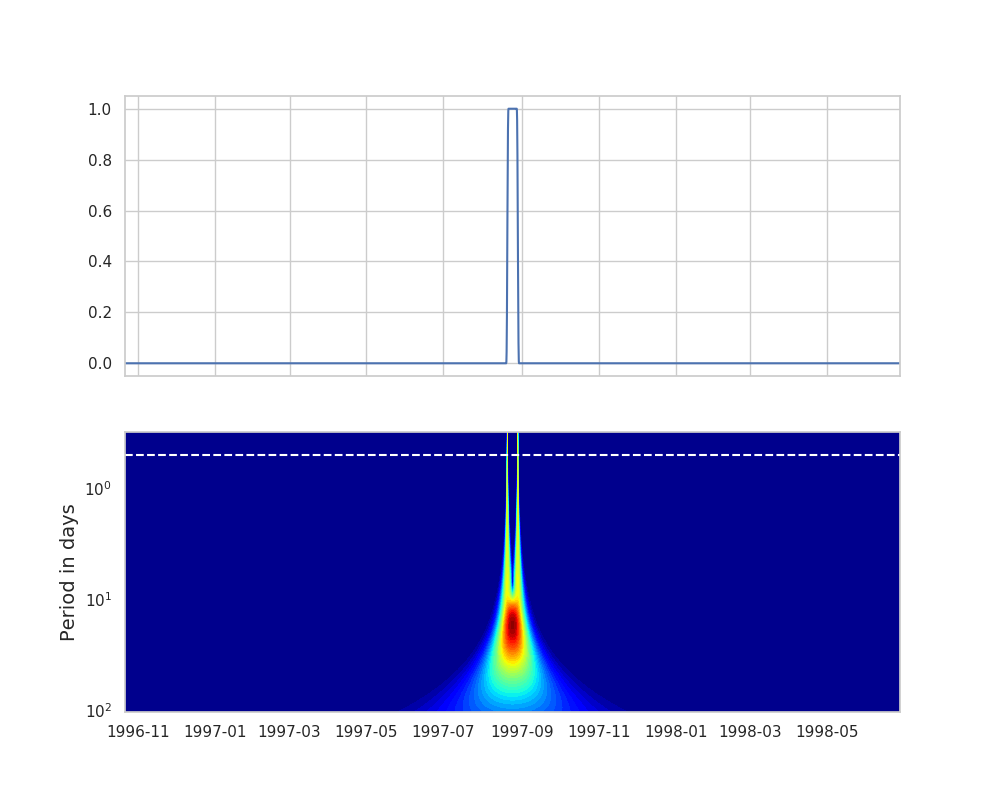

"u=zeros(size(cv(:,4)));               %Create a time series of zeros the same length as my data\nu(round(end/2)-50:round(end/2)+50)=1; %Set the central 101 points to a value of one\n%This is all essentially the same as before\ngamma=3;beta=2;\nfs=morsespace(gamma,beta,length(u));\nwu=wavetrans(u,{gamma,beta,fs});\nclf,\nh=wavespecplot(yearfrac(num),vfilt(u,24),dt./(fs/2/pi),wu);  %Convert rad/day to cycles/day\naxes(h(1)),ylim([-.1 1.1])\naxes(h(2)),hlines(1./(tidefreq('m2')*24/2/pi),'w--')         %Convert rad/hour to cycles/day\nylabel('Period (days)')"

In [48]:
u = np.zeros(len(cv[3]))
u[round(len(u)/2)-50:round(len(u)/2)+50]=1

gamma = 3
beta = 2

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))
psi, psif = morse.make_wavelet(len(u), fs)
transform = analytic_wavelet.analytic_wavelet_transform(u, psif, False)

window = signal.windows.hann(24)
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed)  # internal function for plotting time series

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform,
                                      levels=50,
                                      cmap=cmap
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].set_ylabel("Period in days", fontsize=14)
ax[1].invert_yaxis()
ax[1].set_yscale("log")

<IPython.core.display.Javascript object>


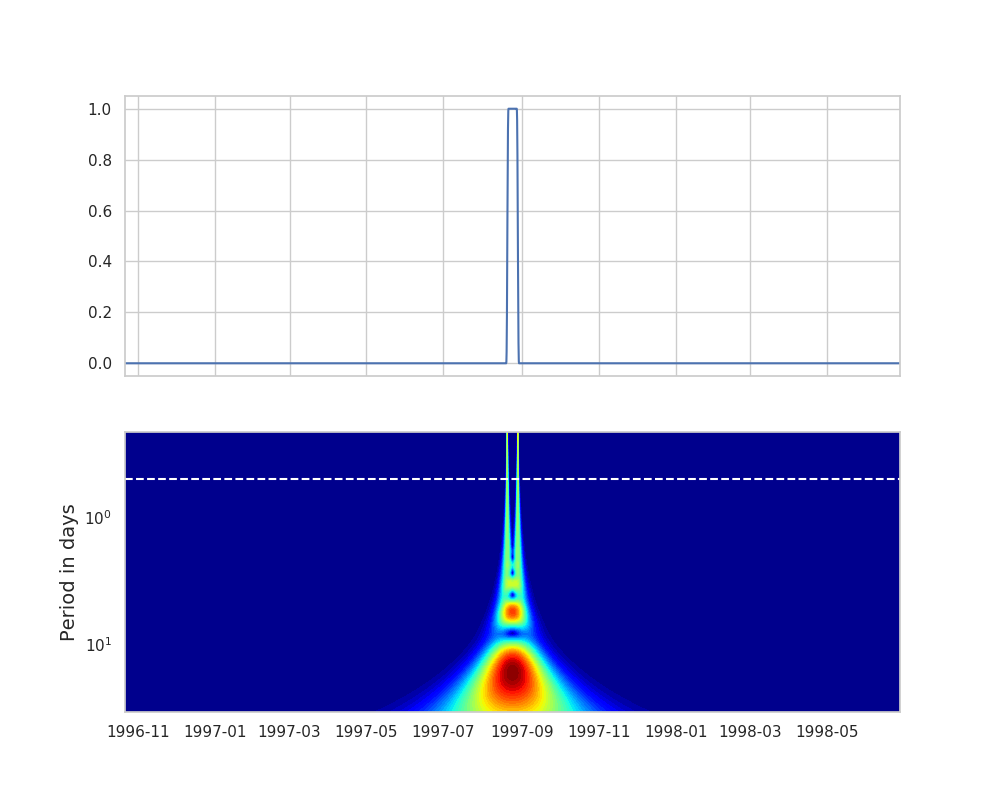

In [49]:
gamma = 3
beta = 20

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))
psi, psif = morse.make_wavelet(len(u), fs)
transform = analytic_wavelet.analytic_wavelet_transform(u, psif, False)

window = signal.windows.hann(24)
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed)  # internal function for plotting time series

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform,
                                      levels=50,
                                      cmap=cmap
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].set_ylabel("Period in days", fontsize=14)
ax[1].invert_yaxis()
ax[1].set_yscale("log")

next figure

<IPython.core.display.Javascript object>


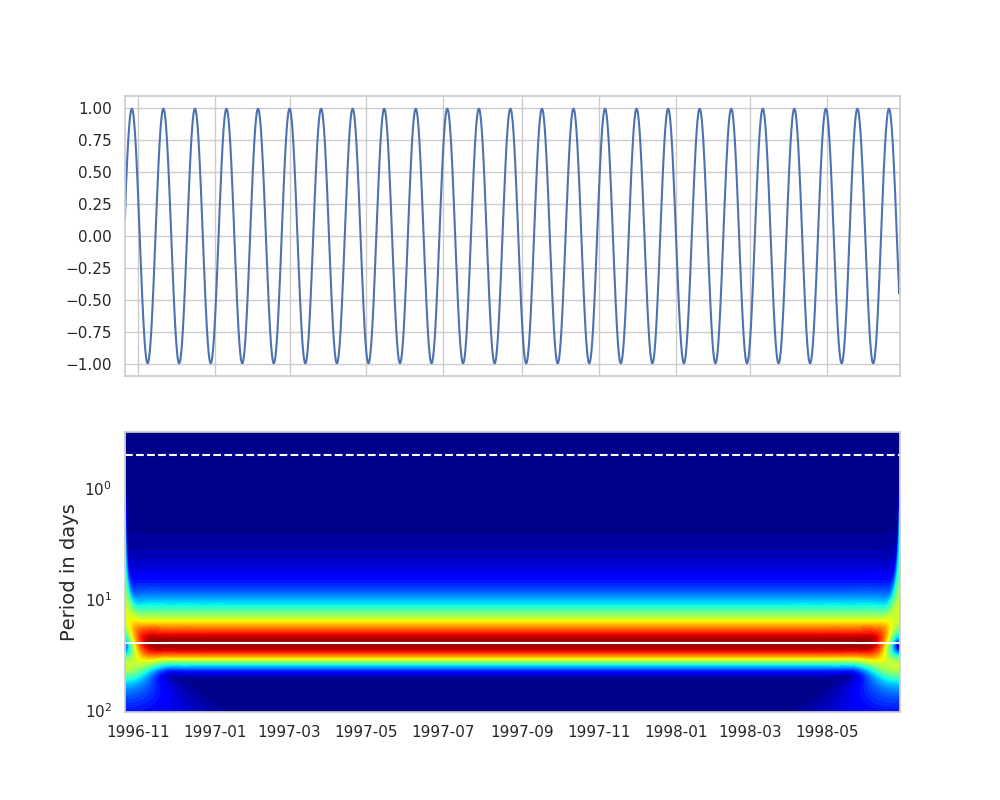

In [58]:
u = np.cos(2*np.pi*2*num_old/50)  # remember num_old?

gamma = 3
beta = 2

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))
psi, psif = morse.make_wavelet(len(u), fs)
transform = analytic_wavelet.analytic_wavelet_transform(u, psif, False)

window = signal.windows.hann(24)
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed)  # internal function for plotting time series

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform,
                                      levels=50,
                                      cmap=cmap
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].axhline(1/(2/50), color="white")
ax[1].set_ylabel("Period in days", fontsize=14)
ax[1].invert_yaxis()
ax[1].set_yscale("log")

increasing beta

<IPython.core.display.Javascript object>


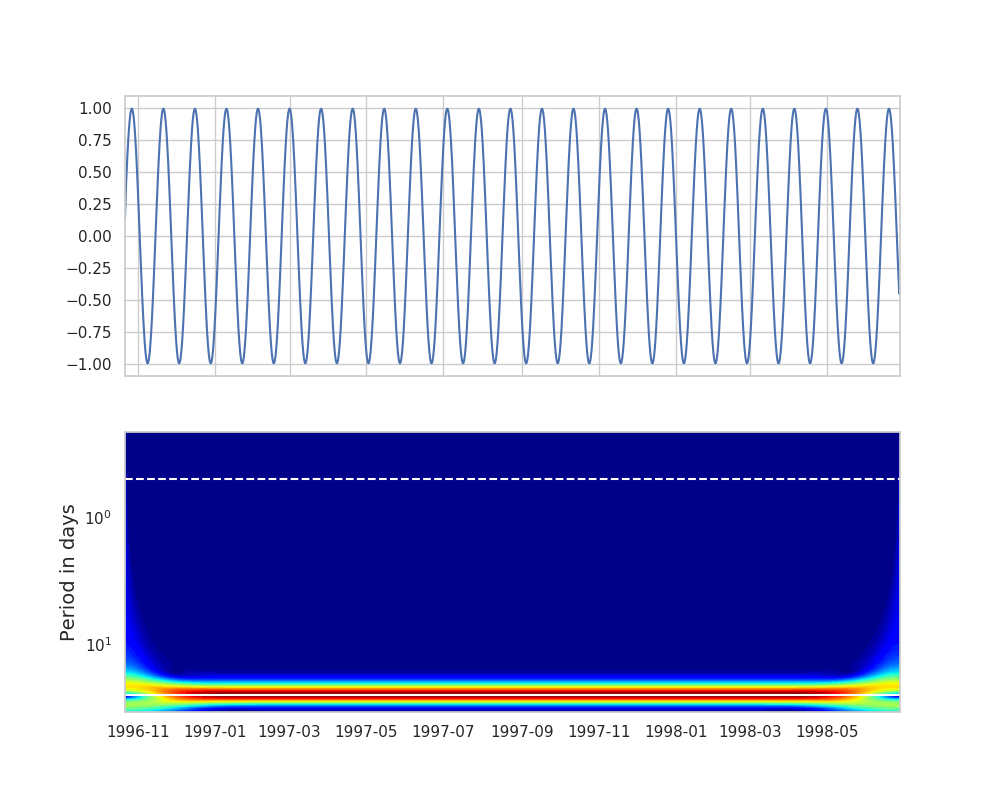

In [59]:
u = np.cos(2*np.pi*2*num_old/50)  # remember num_old?

gamma = 3
beta = 20

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))
psi, psif = morse.make_wavelet(len(u), fs)
transform = analytic_wavelet.analytic_wavelet_transform(u, psif, False)

window = signal.windows.hann(24)
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed)  # internal function for plotting time series

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform,
                                      levels=50,
                                      cmap=cmap
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].axhline(1/(2/50), color="white")
ax[1].set_ylabel("Period in days", fontsize=14)
ax[1].invert_yaxis()
ax[1].set_yscale("log")

bivariate spectra

<IPython.core.display.Javascript object>


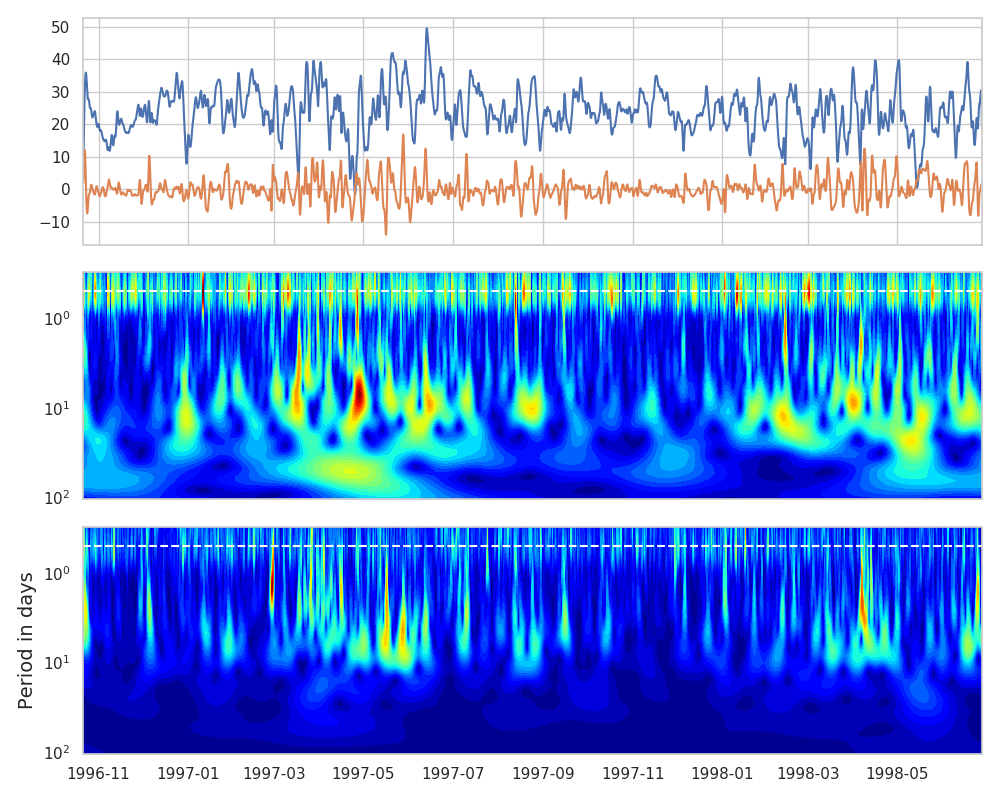

In [70]:
delta = data["num"][1] - data["num"][0]  # sample rate as dt.timedelta object
delta = delta.seconds/60/60/24  # sample rate in days

phi = np.angle(np.mean(cv[3]))

u = (cv[3]*np.exp(-phi*1j))

gamma = 3
beta = 2

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)  # create morse wavelet object (class instance)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))  # use object to construct frequency space
psi, psif = morse.make_wavelet(len(u), fs)  # use object to create a morse wavelet in time and frequency space

transform_real = analytic_wavelet.analytic_wavelet_transform(u.real, psif, False)
transform_imag = analytic_wavelet.analytic_wavelet_transform(u.imag, psif, False)


window = signal.windows.hann(24)  # construct Hanning window
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)  # smooth by convolving speed with window

fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed.real)  # internal function for plotting time series
analytic_wavelet.time_series_plot(ax[0], num, u_smoothed.imag)

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform_real,
                                      levels=30,
                                      cmap=cmap,
                                      vmin=0,
                                      vmax=15
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].set_yscale("log")
ax[1].invert_yaxis()

c = analytic_wavelet.wavelet_contourf(ax[2], num, delta/(fs/2/np.pi), transform_imag,
                                      levels=30,
                                      cmap=cmap,
                                      vmin=0,
                                      vmax=15
                                     )
ax[2].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[2].set_ylabel("Period in days", fontsize=14)
ax[2].set_yscale("log")
ax[2].invert_yaxis()

#fig.colorbar(c, ax=ax[1])
fig.tight_layout()

rotary wavelet spectrum

<IPython.core.display.Javascript object>


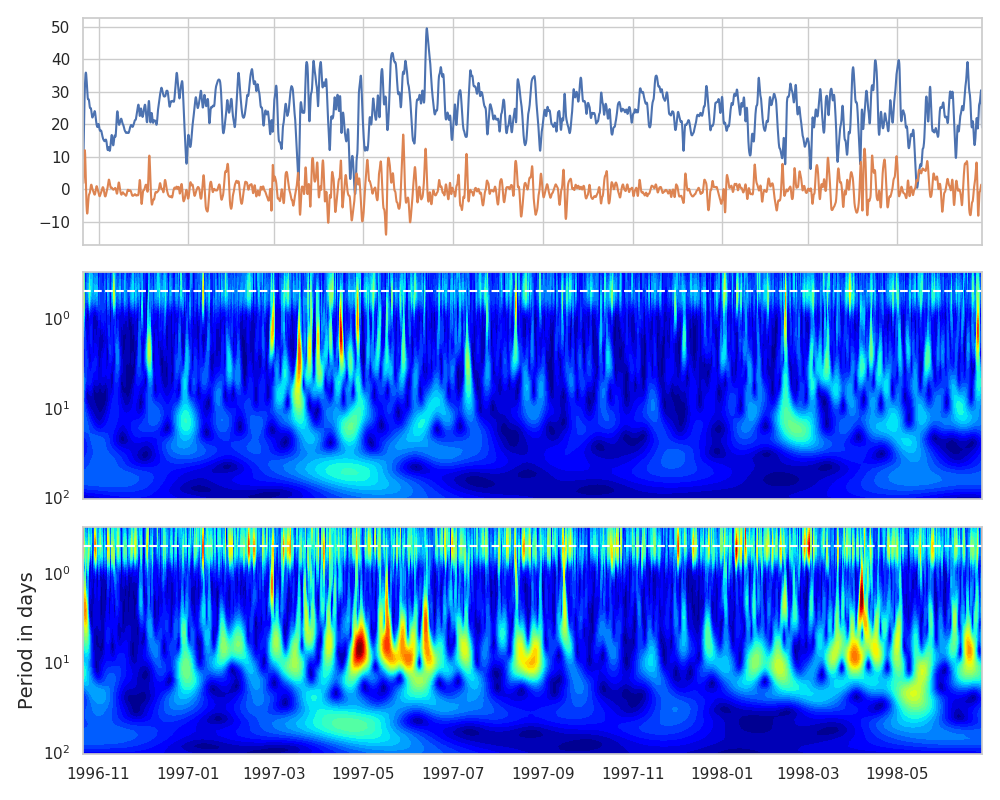

In [71]:
transform = analytic_wavelet.analytic_wavelet_transform(u, psif, False)
transform_conj = analytic_wavelet.analytic_wavelet_transform(np.conj(u), psif, False)


window = signal.windows.hann(24)  # construct Hanning window
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)  # smooth by convolving speed with window

fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed.real)  # internal function for plotting time series
analytic_wavelet.time_series_plot(ax[0], num, u_smoothed.imag)

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform,
                                      levels=30,
                                      cmap=cmap,
                                      vmin=0,
                                      vmax=15
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].set_yscale("log")
ax[1].invert_yaxis()

c = analytic_wavelet.wavelet_contourf(ax[2], num, delta/(fs/2/np.pi), transform_conj,
                                      levels=30,
                                      cmap=cmap,
                                      vmin=0,
                                      vmax=15
                                     )
ax[2].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[2].set_ylabel("Period in days", fontsize=14)
ax[2].set_yscale("log")
ax[2].invert_yaxis()

#fig.colorbar(c, ax=ax[1])
fig.tight_layout()

Lets now change beta

<IPython.core.display.Javascript object>


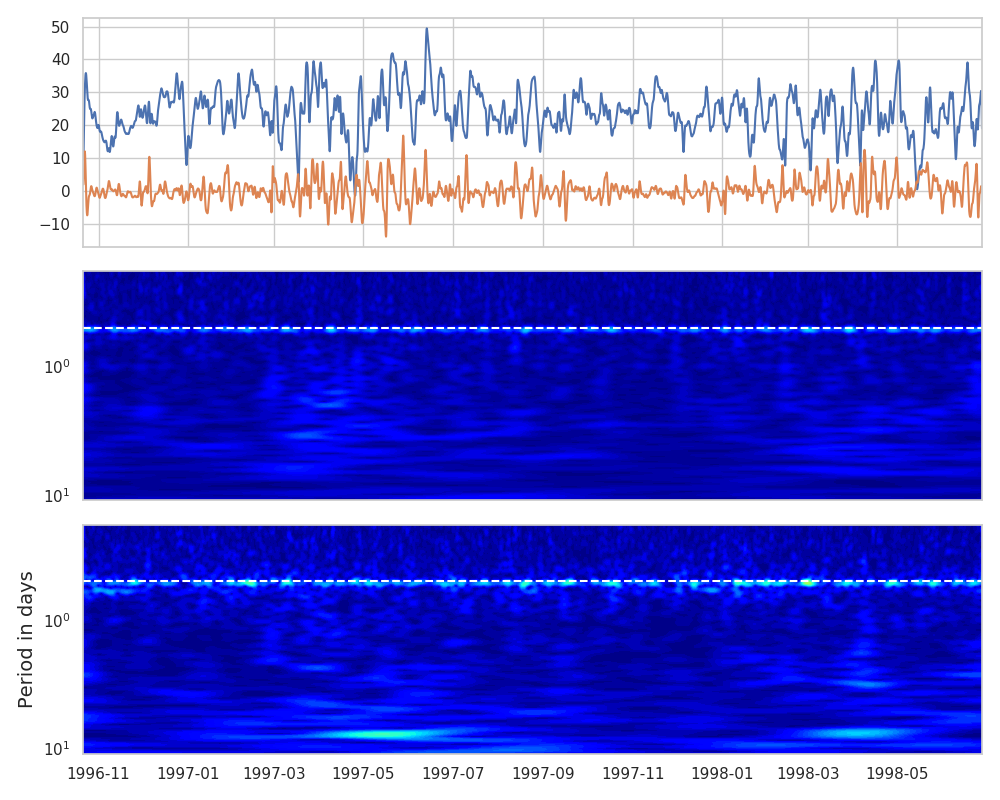

In [79]:
gamma = 3
beta = 200

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)  # create morse wavelet object (class instance)
fs = morse.log_spaced_frequencies(num_timepoints=len(u))  # use object to construct frequency space
psi, psif = morse.make_wavelet(len(u), fs)  # use object to create a morse wavelet in time and frequency space

transform = analytic_wavelet.analytic_wavelet_transform(u, psif, False)
transform_conj = analytic_wavelet.analytic_wavelet_transform(np.conj(u), psif, False)


window = signal.windows.hann(24)  # construct Hanning window
u_smoothed = signal.convolve(u, window, mode="same") / np.sum(window)  # smooth by convolving speed with window

fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

analytic_wavelet.time_series_plot(ax[0], num, u_smoothed.real)  # internal function for plotting time series
analytic_wavelet.time_series_plot(ax[0], num, u_smoothed.imag)

cmap = plt.cm.get_cmap("jet")  # choose colormap (this one is quite hard to look at)
# internal function for constructing contourf plot. Takes plt.contourf **kwargs
c = analytic_wavelet.wavelet_contourf(ax[1], num, delta/(fs/2/np.pi), transform,
                                      levels=30,
                                      cmap=cmap,
                                      vmin=0,
                                      vmax=15
                                     )
ax[1].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[1].set_yscale("log")
ax[1].invert_yaxis()

c = analytic_wavelet.wavelet_contourf(ax[2], num, delta/(fs/2/np.pi), transform_conj,
                                      levels=30,
                                      cmap=cmap,
                                      vmin=0,
                                      vmax=15
                                     )
ax[2].axhline(0.5, linestyle="dashed", color="white")  # construct a white horizontal line
ax[2].set_ylabel("Period in days", fontsize=14)
ax[2].set_yscale("log")
ax[2].invert_yaxis()

#fig.colorbar(c, ax=ax[1])
fig.tight_layout()